In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from scipy.special import erf
from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import StrMethodFormatter, NullFormatter
import matplotlib.patheffects as path_effects
import scipy.ndimage
import illustris_python as il

# Universal constants
c = 2.99792458e10          # Speed of light [cm/s]
kB = 1.380648813e-16       # Boltzmann's constant [g cm^2/s^2/K]
h = 6.626069573e-27        # Planck's constant [erg/s]
mH = 1.6735327e-24         # Mass of hydrogen atom [g]
me = 9.109382917e-28       # Electron mass [g]
ee = 4.80320451e-10        # Electron charge [g^(1/2) cm^(3/2) / s]

# Emperical unit definitions
Msun = 1.988435e33         # Solar mass [g]
Lsun = 3.839e33            # Solar luminosity [erg/s]
Zsun = 0.0134              # Solar metallicity (mass fraction)
arcsec = 648000. / np.pi   # arseconds per radian
pc = 3.085677581467192e18  # Units: 1 pc  = 3e18 cm
kpc = 1e3 * pc             # Units: 1 kpc = 3e21 cm
Mpc = 1e6 * pc             # Units: 1 Mpc = 3e24 cm
km = 1e5                   # Units: 1 km  = 1e5  cm
angstrom = 1e-8            # Units: 1 angstrom = 1e-8 cm
day = 86400.               # Units: 1 day = 24 * 3600 seconds
yr = 365.24 * day          # Units: 1 year = 365.24 days
kyr = 1e3 * yr             # Units: 1 Myr = 10^6 yr
Myr = 1e6 * yr             # Units: 1 Myr = 10^6 yr
lambda0 = 1215.67          # Lyman-alpha wavelength [angstroms]
lambda_1216 = 1215.67 * angstrom # Lyman-alpha wavelength [cm]
lambda_1500 = 1500. * angstrom # Continuum wavelength [cm]
lambda_2500 = 2500. * angstrom # Continuum wavelength [cm]
R_10pc = 10. * pc              # Reference distance for continuum [cm]
fnu_1216_fac = lambda_1216**2 / (4. * np.pi * c * R_10pc**2 * angstrom)
fnu_1500_fac = lambda_1500**2 / (4. * np.pi * c * R_10pc**2 * angstrom)
fnu_2500_fac = lambda_2500**2 / (4. * np.pi * c * R_10pc**2 * angstrom)
E_AGN = 5.29e-11 # Mean photon energy [erg]
E_Lya = h * c / lambda_1216 # Lyman-alpha energy [erg]

sigma_68 = erf(1./np.sqrt(2.))
percentiles = [50., 50.*(1.-sigma_68), 50.*(1.+sigma_68)]
n_percentiles = len(percentiles)

In [2]:
def read_eor(sim):
    data = np.loadtxt(f'/nfs/mvogelsblab001/Thesan/{sim}/output/eor.txt')
    zs = data[:,0]
    x_HIs = data[:,1]
    monotonic = False
    while not monotonic:
        monotonic = True
        for i in range(1,len(zs)):
            if zs[i] >= zs[i-1]:
                monotonic = False
                # print(zs[i],zs[i-1])
                for j in range(len(zs)):
                    if zs[j] <= zs[i]:
                        # print('\t',zs[j])
                        zs = np.hstack([zs[:j],zs[i:]])
                        x_HIs = np.hstack([x_HIs[:j],x_HIs[i:]])
                        break
                break
    zs = np.hstack([zs, zs[-1]-.01, 0.])
    x_HIs = np.hstack([x_HIs, 0., 0.])
    if sim == 'Thesan-1':
        zs = np.hstack([49, zs])
        x_HIs = np.hstack([1, x_HIs])
    print(zs)
    print(x_HIs)
    print(np.min(zs[:-1] - zs[1:]))
#     plt.plot(zs, x_HIs)
#     plt.show()
    return {'z':zs, 'x_HI':x_HIs}

eor_1 = read_eor('Thesan-1')
eor_2 = read_eor("Thesan-2")
eor_low = read_eor("Thesan-Low-2")
eor_high = read_eor("Thesan-High-2")
eor_sdao = read_eor("Thesan-sDAO-2")
eor_wc = read_eor("Thesan-WC-2")

eor = {'Thesan-1': eor_1, 'Thesan-WC-2': eor_wc, 'Thesan-sDAO-2': eor_sdao, 'Thesan-High-2': eor_high, 'Thesan-Low-2': eor_low, 'Thesan-2': eor_2}

[49.      16.1067  16.0368  ...  5.44549  5.43549  0.     ]
[1.         0.999805   0.999794   ... 0.00933228 0.         0.        ]
0.0004299999999997084
[49.     48.7934 48.5876 ...  5.      4.99    0.    ]
[0.999999   0.999999   0.999999   ... 0.00636332 0.         0.        ]
0.00042000000000008697
[49.      48.7934  48.5876  ...  5.55871  5.54871  0.     ]
[0.999999  0.999999  0.999999  ... 0.0039881 0.        0.       ]
0.0004299999999997084
[49.      48.7934  48.5876  ...  5.48444  5.47444  0.     ]
[0.999999  0.999999  0.999999  ... 0.0106448 0.        0.       ]
0.00042000000000008697
[49.      48.7934  48.5876  ...  5.33186  5.32186  0.     ]
[0.999999   0.999999   0.999999   ... 0.00376172 0.         0.        ]
0.00042000000000008697
[49.      48.7934  48.5876  ...  5.24075  5.23075  0.     ]
[0.999999   0.999999   0.999999   ... 0.00489038 0.         0.        ]
0.00042000000000008697


In [3]:
def read_Lya(snap=70, sim='Thesan-1'):
    print(f'Reading snapshot {snap} ...')
    basePath = f'/nfs/mvogelsblab001/Thesan/{sim}/output'
    fields = ['SubhaloMass','SubhaloSFRinRad','SubhaloLenType','SubhaloMassType','SubhaloVelDisp','SubhaloPos','SubhaloGrNr','SubhaloStarMetallicity']
    s = il.groupcat.loadSubhalos(basePath, snap, fields=fields)

    s['snap'] = snap
    s['basePath'] = basePath
    Lya_filename = basePath + f'/../postprocessing/Lya/Lya_{snap:03d}.hdf5'
    with h5py.File(Lya_filename, 'r') as f:
        g = f['Header']
        for key in ['BoxSize', 'EscapeFraction', 'Omega0', 'OmegaBaryon', 'OmegaLambda', 'HubbleParam', 'Time', 'Redshift']:
            s[key] = g.attrs[key]
#         BoxSize = g.attrs['BoxSize']
#         EscapeFraction = g.attrs['EscapeFraction']
#         Omega0 = g.attrs['Omega0']
#         OmegaBaryon = g.attrs['OmegaBaryon']
#         OmegaLambda = g.attrs['OmegaLambda']
        h = g.attrs['HubbleParam']
        a = g.attrs['Time']
        z = g.attrs['Redshift']
        UnitLength_in_cm = g.attrs['UnitLength_in_cm']
        UnitMass_in_g = g.attrs['UnitMass_in_g']
        UnitVelocity_in_cm_per_s = g.attrs['UnitVelocity_in_cm_per_s']
        UnitTime_in_s = UnitLength_in_cm / UnitVelocity_in_cm_per_s
        UnitEnergy_in_cgs = UnitMass_in_g * UnitVelocity_in_cm_per_s * UnitVelocity_in_cm_per_s
        UnitLum_in_cgs = UnitEnergy_in_cgs / UnitTime_in_s
        length_to_cgs = a * UnitLength_in_cm / h
        length_to_kpc = length_to_cgs / kpc
        volume_to_cgs = length_to_cgs * length_to_cgs * length_to_cgs
        s['BoxSize_Mpc'] = s['BoxSize'] * length_to_cgs / Mpc # Box size in Mpc (physical)
        s['V_box_Mpc3'] = s['BoxSize_Mpc']**3 # Box volume in Mpc^3 (physical)
        s['V_box_cMpc3'] = s['V_box_Mpc3'] / s['Time']**3
        mass_to_cgs = UnitMass_in_g / h
        mass_to_Msun = mass_to_cgs / Msun

        s['SubhaloMass'] = mass_to_Msun * s['SubhaloMass'] # Msun

        s['Lya'] = UnitLum_in_cgs * f['Subhalo']['LyaLum'][:].astype(np.float64) # Lya = LyaCol + LyaRec + LyaStars
        s['LyaCol'] = UnitLum_in_cgs * f['Subhalo']['LyaLumCol'][:].astype(np.float64) # erg/s
        s['LyaRec'] = UnitLum_in_cgs * f['Subhalo']['LyaLumRec'][:].astype(np.float64) # erg/s
        s['LyaStars'] = UnitLum_in_cgs * f['Subhalo']['LyaLumStars'][:].astype(np.float64) # erg/s
        s['L1216'] = UnitLum_in_cgs * f['Subhalo']['1216LumStars'][:].astype(np.float64) # erg/s/Angstrom
        s['L1500'] = UnitLum_in_cgs * f['Subhalo']['1500LumStars'][:].astype(np.float64) # erg/s/Angstrom
        s['L2500'] = UnitLum_in_cgs * f['Subhalo']['2500LumStars'][:].astype(np.float64) # erg/s/Angstrom
        
        dtm = 0.9 * (z/2.)**-1.92 # Vogelsberger+2020
        tau_dust_1216 = 8.8 * (1500./1215.67)**1.1 * (s['SubhaloStarMetallicity'][:]/0.0127) * (dtm/0.44) # empirical UV dust correction from Gnedin (2014)
        tau_dust_1500 = 8.8 * (1500./1500.)**1.1 * (s['SubhaloStarMetallicity'][:]/0.0127) * (dtm/0.44)
        tau_dust_2500 = 8.8 * (1500./2500.)**1.1 * (s['SubhaloStarMetallicity'][:]/0.0127) * (dtm/0.44)
        
        fesc_min = 0.208
        f_esc_Lya = np.zeros(len(s['Lya']))
        log_Mhalo_min = 11.017
        log_Mhalo_max = 11.342
        loghalos = np.log10(s['SubhaloMass'])
        for i in range(len(loghalos)):
            loghalo = loghalos[i]
            if loghalo < log_Mhalo_min:
                f_esc_Lya[i] = 1.
            elif loghalo > log_Mhalo_max:
                f_esc_Lya[i] = fesc_min
            else:
                f_esc_Lya[i] = 1. + (loghalo - log_Mhalo_min) * (fesc_min - 1.)/(log_Mhalo_max - log_Mhalo_min)
        
        fesc_1216 = np.exp(-tau_dust_1216)
        mask = (fesc_1216 < f_esc_Lya)
        fesc_1216[mask] = f_esc_Lya[mask]
        
        fesc_1500 = np.exp(-tau_dust_1500)
        s['L1500_obs_nolim'] = UnitLum_in_cgs * f['Subhalo_NoSFH']['1500LumStars'][:].astype(np.float64) * fesc_1500
        mask = (fesc_1500 < f_esc_Lya)
        fesc_1500[mask] = f_esc_Lya[mask]
        
        fesc_2500 = np.exp(-tau_dust_2500)
        mask = (fesc_2500 < f_esc_Lya)
        fesc_2500[mask] = f_esc_Lya[mask]

#         fesc_1216 = f_esc_Lya
#         fesc_1500 = f_esc_Lya
#         fesc_2500 = f_esc_Lya
        
        s['L1500_obs'] = UnitLum_in_cgs * f['Subhalo_NoSFH']['1500LumStars'][:].astype(np.float64) * fesc_1500
        s['L2500_obs'] = UnitLum_in_cgs * f['Subhalo_NoSFH']['2500LumStars'][:].astype(np.float64) * fesc_2500
        s['beta_obs'] = np.log(s['L2500_obs']/s['L1500_obs']) / np.log(lambda_2500/lambda_1500)
        s['L1216_obs_est'] = s['L1500_obs'] * (lambda_1216/lambda_1500)**s['beta_obs'] # erg/s/Angstrom
        
#         s['beta'] = np.log(s['L2500']/s['L1500']) / np.log(lambda_2500/lambda_1500)
#         s['L1216_est'] = s['L1500'] * (lambda_1216/lambda_1500)**s['beta'] # erg/s/Angstrom
        
        s['M1216'] = -2.5 * np.log10(fnu_1216_fac * s['L1216']) - 48.6 # Continuum absolute magnitude
        s['M1500'] = -2.5 * np.log10(fnu_1500_fac * s['L1500']) - 48.6 # Continuum absolute magnitude
        s['M2500'] = -2.5 * np.log10(fnu_2500_fac * s['L2500']) - 48.6 # Continuum absolute magnitude
        
        s['M1500_obs'] = -2.5 * np.log10(fnu_1500_fac * s['L1500_obs']) - 48.6 # Continuum absolute magnitude
        s['M1500_obs_nolim'] = -2.5 * np.log10(fnu_1500_fac * s['L1500_obs_nolim']) - 48.6
        
        # option 1
#         EW = f['Subhalo_NoSFH']['LyaLum'][:].astype(np.float64) / f['Subhalo_NoSFH']['1216LumStars'][:].astype(np.float64)
#         s['EW_halfobs'] = EW / fesc_1216
        
        # option 2
        s['EW_halfobs'] = UnitLum_in_cgs * f['Subhalo_NoSFH']['LyaLum'][:].astype(np.float64) / s['L1216_obs_est'] # this one is not entirely intrinsic. half obs
        
#         s['EW_halfobs'] = UnitLum_in_cgs * f['Subhalo_NoSFH']['LyaLum'][:].astype(np.float64) / s['L1216_est'] #* fesc_1216
    
    # remove low LyaLum values
    otherfields = ['LyaCol', 'LyaRec', 'LyaStars', 
                   'L1216', 'L1500', 'L2500', 'M1216', 'M1500', 'M2500', 'L1500_obs_nolim', 'M1500_obs_nolim',
                   'EW_halfobs', 'L1500_obs', 'L2500_obs', 'beta_obs', 'L1216_obs_est', 'M1500_obs']
    mask = (s['Lya'] > 10**41.5)
    s['Lya'] = s['Lya'][mask]
    for field in fields:
        s[field] = s[field][mask]
    for field in otherfields:
        s[field] = s[field][mask]

    # remove high LyaLum values
    mask = (s['Lya'] < 10**45)
    s['Lya'] = s['Lya'][mask]
    for field in fields:
        s[field] = s[field][mask]
    for field in otherfields:
        s[field] = s[field][mask]
    
    # getting X value to multiply things - gotta do it after the high and low lum cuts, bc x was calculated after those
    if sim=='Thesan-WC-2' or sim=='Thesan-sDAO-2':
        tau_dir = f'/nfs/mvogelsblab001/Lab/thesan-lya/{sim}/tau'
    elif sim=='Thesan-1':
        tau_dir = '/nfs/mvogelsblab001/Thesan/Thesan-1/postprocessing/tau'
    else:
        tau_dir=f'/pool001/users/claraxu/Thesan/{sim}/tau'
    filename = tau_dir + f'/X_emulated/X_emulated_{snap:03d}.hdf5'
    with h5py.File(filename, 'r') as k:
        Xall = k['Xs'][:,:]
        Xp = np.percentile(Xall, percentiles, axis=1)
        X = Xp[0]

    s['EW_obs'] = s['EW_halfobs'] * X
    
    i0 = np.argmin(np.abs(z - eor[sim]['z']))
    s['x_HI'] = eor[sim]['x_HI'][i0]
    
    return s

s13_1 = read_Lya(snap=14, sim='Thesan-1') # z = 13
s11_1 = read_Lya(snap=22, sim='Thesan-1') # z = 11
s10_1 = read_Lya(snap=27, sim='Thesan-1') # z = 10
s9_1 = read_Lya(snap=34, sim='Thesan-1') # z = 9
s8_1 = read_Lya(snap=43, sim='Thesan-1') # z = 8
s7_1 = read_Lya(snap=54, sim='Thesan-1') # z = 7
s6_1 = read_Lya(snap=70, sim='Thesan-1') # z = 6
s5_1 = read_Lya(snap=80, sim='Thesan-1') 

s13_2 = read_Lya(snap=14, sim='Thesan-2') # z = 13
s11_2 = read_Lya(snap=22, sim='Thesan-2') # z = 11
s10_2 = read_Lya(snap=27, sim='Thesan-2') # z = 10
s9_2 = read_Lya(snap=34, sim='Thesan-2') # z = 9
s8_2 = read_Lya(snap=43, sim='Thesan-2') # z = 8
s7_2 = read_Lya(snap=54, sim='Thesan-2') # z = 7
s6_2 = read_Lya(snap=70, sim='Thesan-2') # z = 6
s5_2 = read_Lya(snap=80, sim='Thesan-2') # z = 5.5

s13_low = read_Lya(snap=14, sim='Thesan-Low-2') # z = 13
s11_low = read_Lya(snap=22, sim='Thesan-Low-2') # z = 11
s10_low = read_Lya(snap=27, sim='Thesan-Low-2') # z = 10
s9_low = read_Lya(snap=34, sim='Thesan-Low-2') # z = 9
s8_low = read_Lya(snap=43, sim='Thesan-Low-2') # z = 8
s7_low = read_Lya(snap=54, sim='Thesan-Low-2') # z = 7
s6_low = read_Lya(snap=70, sim='Thesan-Low-2') # z = 6
s5_low = read_Lya(snap=78, sim='Thesan-Low-2') # z = 5.5

s13_high = read_Lya(snap=14, sim='Thesan-High-2') # z = 13
s11_high = read_Lya(snap=22, sim='Thesan-High-2') # z = 11
s10_high = read_Lya(snap=27, sim='Thesan-High-2') # z = 10
s9_high = read_Lya(snap=34, sim='Thesan-High-2') # z = 9
s8_high = read_Lya(snap=43, sim='Thesan-High-2') # z = 8
s7_high = read_Lya(snap=54, sim='Thesan-High-2') # z = 7
s6_high = read_Lya(snap=70, sim='Thesan-High-2') # z = 6
s5_high = read_Lya(snap=80, sim='Thesan-High-2') # z = 5.5

s13_sdao = read_Lya(snap=14, sim='Thesan-sDAO-2') # z = 13
s11_sdao = read_Lya(snap=22, sim='Thesan-sDAO-2') # z = 11
s10_sdao = read_Lya(snap=27, sim='Thesan-sDAO-2') # z = 10
s9_sdao = read_Lya(snap=34, sim='Thesan-sDAO-2') # z = 9
s8_sdao = read_Lya(snap=43, sim='Thesan-sDAO-2') # z = 8
s7_sdao = read_Lya(snap=54, sim='Thesan-sDAO-2') # z = 7
s6_sdao = read_Lya(snap=70, sim='Thesan-sDAO-2') # z = 6
s5_sdao = read_Lya(snap=80, sim='Thesan-sDAO-2') # z = 5.5

s13_wc = read_Lya(snap=14, sim='Thesan-WC-2') # z = 13
s11_wc = read_Lya(snap=22, sim='Thesan-WC-2') # z = 11
s10_wc = read_Lya(snap=27, sim='Thesan-WC-2') # z = 10
s9_wc = read_Lya(snap=34, sim='Thesan-WC-2') # z = 9
s8_wc = read_Lya(snap=43, sim='Thesan-WC-2') # z = 8
s7_wc = read_Lya(snap=54, sim='Thesan-WC-2') # z = 7
s6_wc = read_Lya(snap=70, sim='Thesan-WC-2') # z = 6
s5_wc = read_Lya(snap=80, sim='Thesan-WC-2') # z = 5.5

s13 = {'Thesan-WC-2': s13_wc, 'Thesan-sDAO-2': s13_sdao, 'Thesan-High-2': s13_high, 'Thesan-Low-2': s13_low, 'Thesan-2': s13_2, 'Thesan-1': s13_1}
s11 = {'Thesan-WC-2': s11_wc, 'Thesan-sDAO-2': s11_sdao, 'Thesan-High-2': s11_high, 'Thesan-Low-2': s11_low, 'Thesan-2': s11_2, 'Thesan-1': s11_1}
s10 = {'Thesan-WC-2': s10_wc, 'Thesan-sDAO-2': s10_sdao, 'Thesan-High-2': s10_high, 'Thesan-Low-2': s10_low, 'Thesan-2': s10_2, 'Thesan-1': s10_1}
s9 = {'Thesan-WC-2': s9_wc, 'Thesan-sDAO-2': s9_sdao, 'Thesan-High-2': s9_high, 'Thesan-Low-2': s9_low, 'Thesan-2': s9_2, 'Thesan-1': s9_1}
s8 = {'Thesan-WC-2': s8_wc, 'Thesan-sDAO-2': s8_sdao, 'Thesan-High-2': s8_high, 'Thesan-Low-2': s8_low, 'Thesan-2': s8_2, 'Thesan-1': s8_1}
s7 = {'Thesan-WC-2': s7_wc, 'Thesan-sDAO-2': s7_sdao, 'Thesan-High-2': s7_high, 'Thesan-Low-2': s7_low, 'Thesan-2': s7_2, 'Thesan-1': s7_1}
s6 = {'Thesan-WC-2': s6_wc, 'Thesan-sDAO-2': s6_sdao, 'Thesan-High-2': s6_high, 'Thesan-Low-2': s6_low, 'Thesan-2': s6_2, 'Thesan-1': s6_1}
s5 = {'Thesan-WC-2': s5_wc, 'Thesan-sDAO-2': s5_sdao, 'Thesan-High-2': s5_high, 'Thesan-Low-2': s5_low, 'Thesan-2': s5_2, 'Thesan-1': s5_1}

Reading snapshot 60 ...


<ipython-input-3-63a1ed487286>:85: RuntimeWarning: invalid value encountered in true_divide
  s['beta_obs'] = np.log(s['L2500_obs']/s['L1500_obs']) / np.log(lambda_2500/lambda_1500)
<ipython-input-3-63a1ed487286>:91: RuntimeWarning: divide by zero encountered in log10
  s['M1216'] = -2.5 * np.log10(fnu_1216_fac * s['L1216']) - 48.6 # Continuum absolute magnitude
<ipython-input-3-63a1ed487286>:92: RuntimeWarning: divide by zero encountered in log10
  s['M1500'] = -2.5 * np.log10(fnu_1500_fac * s['L1500']) - 48.6 # Continuum absolute magnitude
<ipython-input-3-63a1ed487286>:93: RuntimeWarning: divide by zero encountered in log10
  s['M2500'] = -2.5 * np.log10(fnu_2500_fac * s['L2500']) - 48.6 # Continuum absolute magnitude
<ipython-input-3-63a1ed487286>:95: RuntimeWarning: divide by zero encountered in log10
  s['M1500_obs'] = -2.5 * np.log10(fnu_1500_fac * s['L1500_obs']) - 48.6 # Continuum absolute magnitude
<ipython-input-3-63a1ed487286>:96: RuntimeWarning: divide by zero encountered 

In [4]:
s_lya = {14: s13, 22: s11, 27: s10, 34: s9, 43: s8, 54: s7, 70: s6, 80: s5}

In [5]:
# these have the sightlines flattened
def read_x_cut(snap, sim):
    if sim=='Thesan-WC-2' or sim=='Thesan-sDAO-2':
        tau_dir = f'/nfs/mvogelsblab001/Lab/thesan-lya/{sim}/tau'
    elif sim=='Thesan-1':
        tau_dir = '/nfs/mvogelsblab001/Thesan/Thesan-1/postprocessing/tau'
    else:
        tau_dir=f'/pool001/users/claraxu/Thesan/{sim}/tau'
    
    s = {'snap': snap}
    
    filename = tau_dir + f'/X_emulated/X_emulated_{snap:03d}.hdf5'
    
    if sim == 'Thesan-Low-2' and snap == 78:
        new_snap = 80 # for s_lya identification purposes
    else:
        new_snap = snap
    
    with h5py.File(filename, 'r') as f:
        s['X'] = f['Xs'][:,:]
        
        # luminosity and EW cut
        lumcut = s_lya[new_snap][sim]['M1500']
        if snap==14:
            mask = (lumcut < -15.5)
        elif snap==22:
            mask = (lumcut < -16.5)
        elif snap==27:
            mask = (lumcut < -17.5)
        elif snap==34:
            mask = (lumcut < -18.5)
        else:
            mask = (lumcut < -19.)
#         EW_obs = s_lya[new_snap][sim]['EW_obs']
#         mask = ((lumcut < -18.75) & (lumcut > -20.25) & (EW_obs > 25.))
        s['X'] = s['X'][mask,:]
        
        xflat = s['X'].flatten()
        
        if len(s['X']) == 0:
            s['X_50'] = 0
            s['X_16'] = 0
            s['X_84'] = 0
        else:
            X_p = np.percentile(xflat, percentiles)
            s['X_50'] = X_p[0]
            s['X_16'] = X_p[1]
            s['X_84'] = X_p[2]
    
    return s

def read_x_z_cut(sim):
    if sim == 'Thesan-Low-2':
        snaps=[14, 22, 27, 34, 43, 54, 70, 78]
    else:
        snaps=[14, 22, 27, 34, 43, 54, 70, 80]
    s = {'snaps': snaps}
    n_snaps = len(snaps)
    
    s['X_50'] = np.zeros(n_snaps)
    s['X_16'] = np.zeros(n_snaps)
    s['X_84'] = np.zeros(n_snaps)
    
    for i in range(n_snaps):
        snap = snaps[i]
        ds = read_x_cut(snap, sim)
        
        s['X_50'][i] = ds['X_50']
        s['X_16'][i] = ds['X_16']
        s['X_84'][i] = ds['X_84']
        
    return s

In [11]:
s = read_x_z_cut('Thesan-1')

In [14]:
print(s['X_50'])
print(s['X_50']-s['X_16'])
print(s['X_84']-s['X_50'])

[0.00073038 0.00663294 0.03463778 0.07967785 0.14128952 0.22020131
 0.29318996 0.2879259 ]
[1.49791974e-04 3.09655836e-03 2.44661048e-02 5.39450772e-02
 8.67346381e-02 1.41740208e-01 1.98081937e-01 2.00083773e-01]
[0.00284577 0.01772197 0.04136378 0.06379648 0.09044629 0.11366984
 0.12387731 0.1420218 ]


In [21]:
s = read_x_cut(22, 'Thesan-1')
print(s['X_50'])
print(s['X_84']-s['X_50'])
print(s['X_50']-s['X_16'])

0.006632936652749777
0.01772197210236071
0.0030965583590981944


In [32]:
s = read_x_cut(70, 'Thesan-1')

f_cov = 0.1
n_LOS = 768

y = np.count_nonzero(s['X'] < f_cov, axis=1).astype(np.float64)/float(n_LOS)
y_p = np.percentile(y, percentiles)
print(y_p)
print(y_p[0])
print(y_p[2]-y_p[0])
print(y_p[0]-y_p[1])

[0.07291667 0.046875   0.15003681]
0.07291666666666667
0.07712014195017207
0.02604166666666667


In [6]:
# does not have the luminosity cut bc the only thing we use it for is the covering fractions, dependent on M1500
def read_x(snap, sim):
    if sim=='Thesan-WC-2' or sim=='Thesan-sDAO-2':
        tau_dir = f'/nfs/mvogelsblab001/Lab/thesan-lya/{sim}/tau'
    elif sim=='Thesan-1':
        tau_dir = '/nfs/mvogelsblab001/Thesan/Thesan-1/postprocessing/tau'
    else:
        tau_dir=f'/pool001/users/claraxu/Thesan/{sim}/tau'
    
    s = {'snap': snap}
    
    filename = tau_dir + f'/X_emulated/X_emulated_{snap:03d}.hdf5'
    
    if sim == 'Thesan-Low-2' and snap == 78:
        new_snap = 80 # for s_lya identification purposes
    else:
        new_snap = snap
    
    with h5py.File(filename, 'r') as f:
        s['X'] = f['Xs'][:][:]
        # EW cut
        EW_obs = s_lya[new_snap][sim]['EW_obs']
        mask = (EW_obs > 25.)
        s['X'] = s['X'][mask,:]
    
    return s

def read_x_nodust(snap, sim):
    if sim=='Thesan-WC-2' or sim=='Thesan-sDAO-2':
        tau_dir = f'/nfs/mvogelsblab001/Lab/thesan-lya/{sim}/tau'
    elif sim=='Thesan-1':
        tau_dir = '/nfs/mvogelsblab001/Thesan/Thesan-1/postprocessing/tau'
    else:
        tau_dir=f'/pool001/users/claraxu/Thesan/{sim}/tau'
    
    s = {'snap': snap}
    
    filename = tau_dir + f'/X_emulated/X_emulated_nodust_{snap:03d}.hdf5'
    
    if sim == 'Thesan-Low-2' and snap == 78:
        new_snap = 80 # for s_lya identification purposes
    else:
        new_snap = snap
    
    with h5py.File(filename, 'r') as f:
        s['X'] = f['Xs'][:][:]
        # EW cut
        EW_obs = s_lya[new_snap][sim]['EW_obs']
        mask = (EW_obs > 25.)
        s['X'] = s['X'][mask,:]
    
    return s

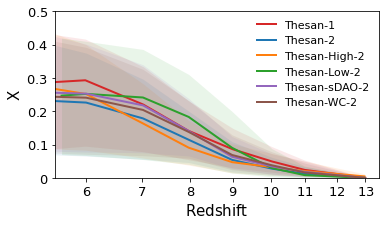

In [21]:
def plot_z_x():
    sims = ['Thesan-1', 'Thesan-2', 'Thesan-High-2', 'Thesan-Low-2', 'Thesan-sDAO-2', 'Thesan-WC-2']
    colors = {'Thesan-1': 'C3', 'Thesan-2': 'C0', 'Thesan-High-2': 'C1', 'Thesan-Low-2': 'C2', 'Thesan-sDAO-2': 'C4', 'Thesan-WC-2': 'C5'}
    
    fig = plt.figure(figsize=(4.5,3.3))
    ax = plt.axes([0,.3,1,.7])
    
    ax.set_xlabel(r'${\rm Redshift}$', fontsize=15)
    ax.set_ylabel('X', fontsize=15)
    ax.set_xscale('log')
    xmin, xmax = [5.5, 13.5]
    x_lims = [5.5, 13.5]
    ymin, ymax = [0., 0.5]
    y_lims = [0., 0.5]
    ax.set_xlim(x_lims)
    ax.set_ylim(y_lims)
    
    ticks = np.linspace(6, 13, 8)
    ax.set_xticks(ticks); ax.set_xticklabels([r'$%g$' % tick for tick in ticks], fontsize=13)
    ticks = np.linspace(ymin, ymax, 6)
    ax.set_yticks(ticks); ax.set_yticklabels([r'$%g$' % tick for tick in ticks], fontsize=13)
    
    for sim in sims:
        ss = [s13, s11, s10, s9, s8, s7, s6, s5]
        s = read_x_z_cut(sim)
        n_zs = 8
        
        x_50 = [ss[i][sim]['Redshift'] for i in range(n_zs)]
        
        y_50 = s['X_50'][:]
        y_16 = s['X_16'][:]
        y_84 = s['X_84'][:]

        ax.fill_between(x_50, y_16, y_84, lw=0., color=colors[sim], alpha=.1)
        ax.plot(x_50, y_50, c=colors[sim], lw=2., label=sim)

#     stark_z = np.array([5.87, 7.12])
#     stark_x = np.array([0.54, 0.24])
#     stark_low = np.array([0.43, 0.09])
#     stark_high = np.array([0.65, 0.39])
    
#     fuller_z = np.array([5.6, 6.56])
#     fuller_x = np.array([0.29, 0.43])
#     fuller_high = np.array([0.36,0.57])
#     fuller_low = np.array([0.25, 0.33])
    
#     debarros_z = np.array([6.0])
#     debarros_x = np.array([0.36])
#     debarros_high = np.array([0.47])
#     debarros_low = np.array([0.28])

#     schenker_z = np.array([7.0, 8.0])
#     schenker_x = np.array([0.24, 0])
#     schenker_high = np.array([0.35, 0.09])
#     schenker_low = np.array([0.18, 0])

#     hoag_z = np.array([7.195])
#     hoag_x = np.array([0.05])
#     hoag_high = np.array([0.07])
#     hoag_low = np.array([0.01])
    
#     pentericci_z = np.array([7.0])
#     pentericci_x = np.array([0.14])
#     pentericci_high = np.array([0.22])
#     pentericci_low = np.array([0.07])

#     tilvi_z = np.array([7.82])
#     tilvi_x = np.array([0.25])
    
#     cross_z = np.array([7.90])
#     cross_x = np.array([0.11])
    
#     kwargs = {'zorder':20, 'alpha':1., 'color':[.3,.3,.3], 'lw':0., 'elinewidth':1.}
#     # 'ms':2, 'elinewidth':1., 'lw':0., 
#     ax.errorbar(stark_z, stark_x, [stark_x-stark_low, stark_high-stark_x], **kwargs, marker='o')
#     ax.errorbar(fuller_z, fuller_x, [fuller_x-fuller_low, fuller_high-fuller_x], **kwargs, marker='p')
#     ax.errorbar(debarros_z, debarros_x, [debarros_x-debarros_low, debarros_high-debarros_x], **kwargs, marker='^')
#     ax.errorbar(schenker_z, schenker_x, [schenker_x-schenker_low, schenker_high-schenker_x], **kwargs, marker='h')
#     ax.errorbar(hoag_z, hoag_x, [hoag_x-hoag_low, hoag_high-hoag_x], **kwargs, marker='s')
#     ax.errorbar(pentericci_z, pentericci_x, [pentericci_x-pentericci_low, pentericci_high-pentericci_x], **kwargs, marker='*')
#     ax.errorbar(tilvi_z, tilvi_x, yerr=0.1, uplims=True, lolims=False, **kwargs, marker='v')
#     p0, = ax.plot([0], [0], lw=1., c=[.3,.3,.3], label='Observations')
    
    leg = ax.legend(loc='upper right', frameon=False, borderaxespad=0.4, handlelength=1.75, fontsize=11.)
    
    fig.savefig('x_emulated_figures/X_z.pdf', bbox_inches='tight', transparent=True, dpi=300, pad_inches=0.025)
    plt.show()
    plt.close()

plot_z_x()

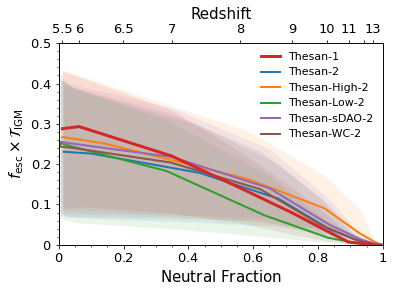

In [7]:
def plot_xHI_x():
    sims = ['Thesan-1', 'Thesan-2', 'Thesan-High-2', 'Thesan-Low-2', 'Thesan-sDAO-2', 'Thesan-WC-2']
    colors = {'Thesan-1': 'C3', 'Thesan-2': 'C0', 'Thesan-High-2': 'C1', 'Thesan-Low-2': 'C2', 'Thesan-sDAO-2': 'C4', 'Thesan-WC-2': 'C5'}
    
    fig = plt.figure(figsize=(4.5,4))
    ax = plt.axes([0,.3,1,.7])
    
    ss = [s13, s11, s10, s9, s8, s7, s6, s5]
    n_zs = 8
    
    for sim in sims:
        s = read_x_z_cut(sim)
        
        x_50 = [ss[i][sim]['x_HI'] for i in range(n_zs)]
        
        y_50 = s['X_50'][:]
        y_16 = s['X_16'][:]
        y_84 = s['X_84'][:]
        
        ax.fill_between(x_50, y_16, y_84, lw=0., color=colors[sim], alpha=.1)
        if sim=='Thesan-1':
            ax.plot(x_50, y_50, c=colors[sim], lw=3., label=sim, zorder=20)
        else:
            ax.plot(x_50, y_50, c=colors[sim], lw=2., label=sim)
    
    #legend
    leg = ax.legend(loc='upper right', frameon=False, borderaxespad=0.4, handlelength=1.75, fontsize=11.)
#     leg2 = ax2.legend(loc='center right', frameon=False, borderaxespad=0.5, handlelength=2.4, ncol=1, fontsize=12.)


    ## Plot labels ##
    ax.set_xlim([0, 1])
    ticks = np.linspace(0, 1, 6)
    ax.set_xticks(ticks); ax.set_xticklabels([r'$%g$' % tick for tick in ticks], fontsize=13)
    ax.set_xlabel(r'${\rm Neutral\ Fraction}$', fontsize=15)

    ax.set_ylabel(r'$f_{\rm esc} \times \mathcal{T}_{\rm IGM}$', fontsize=15)
    ymin, ymax = [0., 0.5]
    y_lims = [0., 0.5]
    ax.set_ylim(y_lims)
    
    ax2 = ax.twiny()
    ticks = [ss[i]['Thesan-1']['x_HI'] for i in range(n_zs)]
    ticks.insert(1, 0.941)
    ticks.insert(7, 0.199)
    ax2.set_xticks(ticks); ax2.set_xticklabels(['13', '', '11', '10', '9', '8', '7', '6.5', '6', '5.5'], fontsize=13)
    ax2.set_xlabel(r'Redshift', fontsize=15)
    
    ax.minorticks_on()
    
    ticks = np.linspace(ymin, ymax, 6)
    ax.set_yticks(ticks); ax.set_yticklabels([r'$%g$' % tick for tick in ticks], fontsize=13)
    fig.savefig('x_emulated_figures/X_xHI.pdf', bbox_inches='tight', transparent=True, dpi=300, pad_inches=0.025)
    plt.show()
    plt.close()

plot_xHI_x()

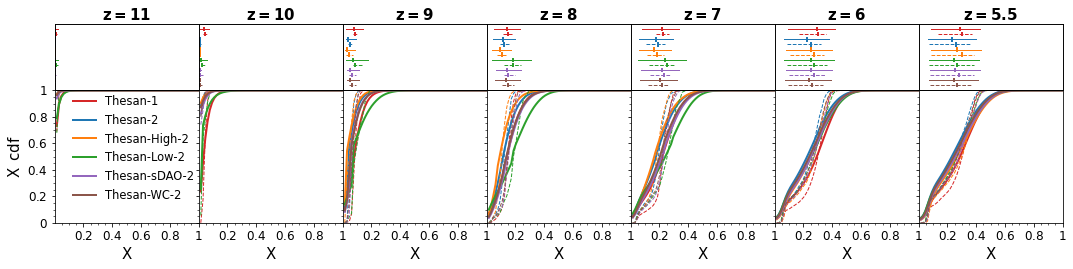

In [21]:
def plot_bands_both():
    n_bands = 5
    dax = 2.
    fax = 1. / float(n_bands)
    fig = plt.figure(figsize=(5.*dax,1.15*dax))
    
    T_min, T_max = 0., 1.
    n_T = 65
    lin_edges = np.linspace(T_min, T_max, n_T)
    lin_centers = (lin_edges[:-1] + lin_edges[1:]) / 2.
    
    n_zs = 7
    titles = ['z = 11', 'z = 10', 'z = 9', 'z = 8', 'z = 7', 'z = 6', 'z = 5.5']
#     log_flags = [True, True, True, False, False]
    sims = ['Thesan-1', 'Thesan-2', 'Thesan-High-2', 'Thesan-Low-2', 'Thesan-sDAO-2', 'Thesan-WC-2']
    n_sims = len(sims)
    snaps = [22, 27, 34, 43, 54, 70, 80]
    colors = {'Thesan-1': 'C3', 'Thesan-2': 'C0', 'Thesan-High-2': 'C1', 'Thesan-Low-2': 'C2', 'Thesan-sDAO-2': 'C4', 'Thesan-WC-2': 'C5'}
    ds = {}
    
    y = np.linspace(0., 1., 2*n_sims+2)[1:-1][::-1]
    ys = {}
    j = 0
    for i in range(2*n_sims):
        if i % 2 == 0:
            sim = sims[j]
        else:
            sim = sims[j] + 'g'
            j += 1
        ys[sim] = y[i]
    dy = 0.25 / float(2*n_sims+2)
    
    for i_z in range(n_zs):
        ax = plt.axes([float(i_z)*fax,0.,fax,.8])
        ax2 = plt.axes([float(i_z)*fax,.8,fax,.4])
        edges = (lin_edges[:]) #(log_edges[:] if log_flags[i_z] else lin_edges[:])
        centers = (lin_centers[:]) #(log_centers[:] if log_flags[i_band] else lin_centers[:])
        
        new_sims = ['Thesan-1', 'Thesan-2', 'Thesan-High-2', 'Thesan-Low-2', 'Thesan-sDAO-2', 'Thesan-WC-2']
        
        lines = []
        for i in range(len(new_sims)):
            sim = new_sims[i]
            snap = snaps[i_z]
            if sim == 'Thesan-Low-2' and snap == 80:
                snap = 78
            s = read_x_cut(snap, sim)
            data = s['X'][:].flatten()
            hist, edges = np.histogram(data, weights=np.ones_like(data), density=False, bins=edges)
            hist /= hist.sum(); cdf = hist.cumsum(); 
            lines += ax.plot(edges[1:], cdf, lw=2., c=colors[sim], label=sim)
            ax2.plot([s['X_16'], s['X_84']], [ys[sim], ys[sim]], lw=1., c=colors[sim])
            ax2.plot([s['X_50'], s['X_50']], [ys[sim]-dy, ys[sim]+dy], lw=2., c=colors[sim])

            if len(s['X']) != 0:
                galaxy_data = np.average(s['X'], axis=1)
                y_50, y_16, y_84 = np.percentile(galaxy_data, percentiles)
                hist, edges = np.histogram(galaxy_data, weights=np.ones_like(galaxy_data), density=False, bins=edges)
                hist /= hist.sum(); cdf = hist.cumsum(); 
                ax.plot(edges[1:], cdf, lw=1., c=colors[sim], label=sim, ls='--')
                ax2.plot([y_16, y_84], [ys[sim+'g'], ys[sim+'g']], lw=1., c=colors[sim], ls='--')
                ax2.plot([y_50, y_50], [ys[sim+'g']-dy, ys[sim+'g']+dy], lw=2., c=colors[sim])
            
        if i_z == 0:
            leg = ax.legend(lines[:], sims[:], loc='upper right', frameon=False, borderaxespad=0., handlelength=2, fontsize=11.5)
        
        ymin, ymax = 0., 1.
        ax.set_ylim([ymin, ymax])
        ticks = np.linspace(ymin, ymax, 6)
        if i_z == 0:
            ax.set_ylabel(r'${\rm X\ \,cdf}$', fontsize=15)
            ax.set_yticks(ticks); ax.set_yticklabels([r'$%g$' % tick for tick in ticks], fontsize=12)
        else:
            ax.set_yticks(ticks); ax.set_yticklabels(['' for tick in ticks], fontsize=13)

        ax.set_xlabel('X', fontsize=15)
        xmin, xmax = 0., 1.
        ax2.set_xlim([xmin, xmax]); ax2.set_xticks([])
        ax.set_xlim([xmin, xmax])
        ticks = np.linspace(xmin, xmax, 6)[1:]
        ax.set_xticks(ticks); ax.set_xticklabels([r'$%g$' % tick for tick in ticks], fontsize=12)
        ax2.set_ylim([0., 1.]); ax2.set_yticks([])
        
        # redshift titles
        ax3 = ax2.twiny()
        ax3.set_xlabel(r'${\bf '+titles[i_z]+'}$', fontsize=15)
        ax3.set_xticks([])
        
#     ymin, ymax = 1e-6, 1.
#     ax.set_ylim([ymin,ymax])
#     Lymin,Lymax = int(np.ceil(np.log10(ymin))), int(np.floor(np.log10(ymax)))
#     ticks = np.linspace(Lymin, Lymax, Lymax-Lymin+1)
#     ax.set_yticks(10**ticks); ax.set_yticklabels([r'$%g$' % tick for tick in ticks], fontsize=13)
        ax.minorticks_on()
    
    fig.savefig('x_emulated_figures/ewX_cdf.pdf', bbox_inches='tight', transparent=True, dpi=300, pad_inches=0.025)
    plt.show()

plot_bands_both()

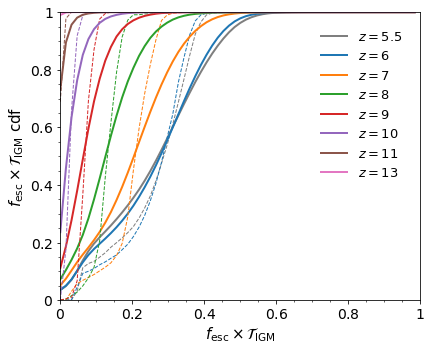

In [29]:
def plot_cdf_single():
    fig = plt.figure(figsize=(5,4))
    ax = plt.axes([0.,0.,1.,1.])
    
    T_min, T_max = 0., 1.
    n_T = 65
    lin_edges = np.linspace(T_min, T_max, n_T)
    lin_centers = (lin_edges[:-1] + lin_edges[1:]) / 2.
    
    snaps = [80, 70, 54, 43, 34, 27, 22, 14]
    labels = [r'$z = 5.5$', r'$z = 6$', r'$z = 7$', r'$z = 8$', r'$z = 9$', r'$z = 10$', r'$z = 11$', r'$z = 13$']
    colors = {14: 'C6', 22: 'C5', 27: 'C4', 34: 'C3', 43: 'C2', 54: 'C1', 70: 'C0', 80: 'C7'}
    
    for i in range(len(snaps)):
        edges = (lin_edges[:]) #(log_edges[:] if log_flags[i_z] else lin_edges[:])
        centers = (lin_centers[:]) #(log_centers[:] if log_flags[i_band] else lin_centers[:])

        sim = 'Thesan-1'
        snap = snaps[i]
        s = read_x_cut(snap, sim)
        data = s['X'][:].flatten()
        hist, edges = np.histogram(data, weights=np.ones_like(data), density=False, bins=edges)
        hist /= hist.sum(); cdf = hist.cumsum(); 
        ax.plot(edges[:-1], cdf, lw=2., c=colors[snap], label=labels[i])

        if len(s['X']) != 0:
            galaxy_data = np.average(s['X'], axis=1)
            y_50, y_16, y_84 = np.percentile(galaxy_data, percentiles)
            hist, edges = np.histogram(galaxy_data, weights=np.ones_like(galaxy_data), density=False, bins=edges)
            hist /= hist.sum(); cdf = hist.cumsum(); 
            ax.plot(edges[:-1], cdf, lw=1., c=colors[snap], ls='--')

        leg = ax.legend(loc='upper right', frameon=False, borderaxespad=1., handlelength=2, fontsize=13)
        
        ymin, ymax = 0., 1.
        ax.set_ylim([ymin, ymax])
        ticks = np.linspace(ymin, ymax, 6)
        ax.set_ylabel(r'$f_{\rm esc} \times \mathcal{T}_{\rm IGM}$ cdf', fontsize=15)
        ax.set_yticks(ticks); ax.set_yticklabels([r'$%g$' % tick for tick in ticks], fontsize=14)

        ax.set_xlabel(r'$f_{\rm esc} \times \mathcal{T}_{\rm IGM}$', fontsize=15)
        xmin, xmax = 0., 1.
        ax.set_xlim([xmin, xmax])
        ticks = np.linspace(xmin, xmax, 6)
        ax.set_xticks(ticks); ax.set_xticklabels([r'$%g$' % tick for tick in ticks], fontsize=14)
        
        ax.minorticks_on()
    
    fig.savefig('x_emulated_figures/ewX_cdf_single.pdf', bbox_inches='tight', transparent=True, dpi=300, pad_inches=0.025)
    plt.show()
    
plot_cdf_single()


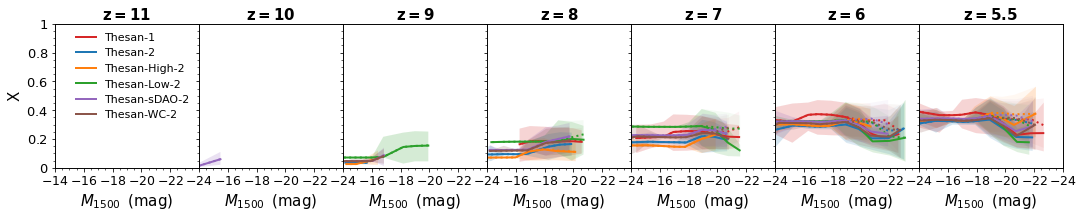

In [58]:
def plot_X_M1500():
    n_bands = 5
    dax = 2.
    fax = 1. / float(n_bands)
    fig = plt.figure(figsize=(5.*dax,dax))
    
    n_zs = 7
    snaps = [22, 27, 34, 43, 54, 70, 80]
    ss = [s11, s10, s9, s8, s7, s6, s5]
    colors = {'Thesan-1': 'C3', 'Thesan-2': 'C0', 'Thesan-High-2': 'C1', 'Thesan-Low-2': 'C2', 'Thesan-sDAO-2': 'C4', 'Thesan-WC-2': 'C5'}
    titles = [r'z = 11', r'z = 10', r'z = 9', r'z = 8', r'z = 7', r'z = 6', r'z = 5.5']
    n_LOS = 12 * 4**3
    
    sims = ['Thesan-1', 'Thesan-2', 'Thesan-High-2', 'Thesan-Low-2', 'Thesan-sDAO-2', 'Thesan-WC-2']
#     sims = ['Thesan-1', 'Thesan-2', 'Thesan-sDAO-2', 'Thesan-WC-2']
    n_sims = len(sims)

    sightline = 0
    
    for i_z in range(n_zs):
        ax = plt.axes([float(i_z)*fax,0.,fax,1.])
        
        new_sims = ['Thesan-1', 'Thesan-2', 'Thesan-High-2', 'Thesan-Low-2', 'Thesan-sDAO-2', 'Thesan-WC-2']
#         new_sims = ['Thesan-1', 'Thesan-2', 'Thesan-sDAO-2', 'Thesan-WC-2']

        for i in range(len(new_sims)):
            sim = new_sims[i]
            snap = snaps[i_z]
            if sim == 'Thesan-Low-2' and snap == 80:
                new_snap = 78
            else:
                new_snap = snap
            
            if sim=='Thesan-WC-2' or sim=='Thesan-sDAO-2':
                tau_dir = f'/nfs/mvogelsblab001/Lab/thesan-lya/{sim}/tau'
            elif sim=='Thesan-1':
                tau_dir = '/nfs/mvogelsblab001/Thesan/Thesan-1/postprocessing/tau'
            else:
                tau_dir=f'/pool001/users/claraxu/Thesan/{sim}/tau'

            # with dust model
            filename = tau_dir + f'/X_emulated/X_emulated_{new_snap:03d}.hdf5'

            with h5py.File(filename, 'r') as f:
                y = f['Xs'][:,:]
                
            xp = np.copy(ss[i_z][sim]['M1500'])
            EW_obs = s_lya[snap][sim]['EW_obs']
            mask = ((EW_obs > 25.) & (xp < 0.))
            
            y = y[mask,:]
            xp = xp[mask]
            n_groups = len(xp)
            x = np.zeros([n_groups, n_LOS])
            for i_LOS in range(n_LOS):
                x[:,i_LOS] = xp[:]
            x = x.flatten()
            y = y.flatten()
            
            x_lims,x_bins = [-24.5, -12.5], 13
            x_edges = np.linspace(x_lims[0], x_lims[1], x_bins)
            
            x_50 = np.zeros(x_bins)
            y_50 = np.zeros(x_bins)
            y_16 = np.zeros(x_bins)
            y_84 = np.zeros(x_bins)
            for ix in range(x_bins-1):
                mask = (x >= x_edges[ix]) & (x < x_edges[ix+1])
                if np.count_nonzero(mask) > 0:
                    x_50[ix] = np.median(x[mask])
                    y_50[ix], y_16[ix], y_84[ix] = np.percentile(y[mask], percentiles)
                else:
                    x_50[ix] = np.NaN
            ax.fill_between(x_50, y_16, y_84, lw=0., color=colors[sim], alpha=.15, zorder=-2*i_z)
            ax.plot(x_50, y_50, c=colors[sim], lw=2., label=sim)
            
            # no dust model
            filename = tau_dir + f'/X_emulated/X_emulated_nodust_{new_snap:03d}.hdf5'

            with h5py.File(filename, 'r') as f:
                y = f['Xs'][:,:]

            xp = np.copy(ss[i_z][sim]['M1500'])
            EW_obs = s_lya[snap][sim]['EW_obs']
            mask = ((EW_obs > 25.) & (xp < 0.))
            
            y = y[mask,:]
            xp = xp[mask]
            n_groups = len(xp)
            x = np.zeros([n_groups, n_LOS])
            for i_LOS in range(n_LOS):
                x[:,i_LOS] = xp[:]
            x = x.flatten()
            y = y.flatten()
            
            x_lims,x_bins = [-24.5, -12.5], 13
            x_edges = np.linspace(x_lims[0], x_lims[1], x_bins)
            
            x_50 = np.zeros(x_bins)
            y_50 = np.zeros(x_bins)
            y_16 = np.zeros(x_bins)
            y_84 = np.zeros(x_bins)
            for ix in range(x_bins-1):
                mask = (x >= x_edges[ix]) & (x < x_edges[ix+1])
                if np.count_nonzero(mask) > 0:
                    x_50[ix] = np.median(x[mask])
                    y_50[ix], y_16[ix], y_84[ix] = np.percentile(y[mask], percentiles)
                else:
                    x_50[ix] = np.NaN
            ax.fill_between(x_50, y_16, y_84, lw=0., color=colors[sim], alpha=.05, zorder=-2*i_z)
            ax.plot(x_50, y_50, c=colors[sim], lw=2., ls=':')
            
        if i_z == 0: leg = ax.legend(loc='upper right', frameon=False, borderaxespad=0.4, handlelength=1.8, ncol=1, fontsize=11.)
        
        ## Plot labels ##
        ax.set_xlabel(r'$M_{1500}\ \,(\rm{mag})$', fontsize=15)
        xmin, xmax = [-24., -14.]
        x_lims = [-24., -14.]
        ax.set_xlim(x_lims)
        ticks = np.linspace(xmin, xmax, int((xmax-xmin)/2+1))
        if i_z > 0: ticks = ticks[:-1]
        ax.set_xticks(ticks); ax.set_xticklabels([r'$%g$' % tick for tick in ticks], fontsize=12.5)
        ax.invert_xaxis()

        y_lims = [0., 1.]
        ymin, ymax = [y_lims[0], y_lims[1]]
        ax.set_ylim(y_lims)
        ticks = np.linspace(ymin, ymax, 6)
        if i_z == 0:
            ax.set_yticks(ticks); ax.set_yticklabels([r'$%g$' % tick for tick in ticks], fontsize=13)
            ax.set_ylabel('X', fontsize=15)
        else:
            ax.set_yticks(ticks); ax.set_yticklabels(['' for tick in ticks], fontsize=13)
        
        ax2 = ax.twiny()
        ax2.set_xlabel(r'${\bf '+titles[i_z]+'}$', fontsize=15)
        ax2.set_xticks([])
        
        ax.minorticks_on()
        
    fig.savefig(f'x_emulated_figures/ewX_M1500.pdf', bbox_inches='tight', transparent=True, dpi=300, pad_inches=0.025)
    plt.show()
    plt.close()

plot_X_M1500()

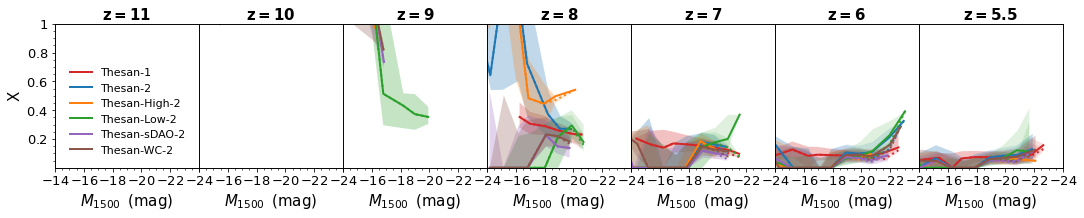

In [59]:
def plot_X_covering_fractions(f_cov=0.1):
    dax = 2.
    fax = 1. / 5.
    fig = plt.figure(figsize=(5.*dax,dax))
    
    n_zs = 7
    snaps = [22, 27, 34, 43, 54, 70, 80]
    ss = [s11, s10, s9, s8, s7, s6, s5]
    colors = {'Thesan-1': 'C3', 'Thesan-2': 'C0', 'Thesan-High-2': 'C1', 'Thesan-Low-2': 'C2', 'Thesan-sDAO-2': 'C4', 'Thesan-WC-2': 'C5'}
    titles = [r'z = 11', r'z = 10', r'z = 9', r'z = 8', r'z = 7', r'z = 6', r'z = 5.5']
    n_LOS = 12 * 4**3
    
    sims = ['Thesan-1', 'Thesan-2', 'Thesan-High-2', 'Thesan-Low-2', 'Thesan-sDAO-2', 'Thesan-WC-2']
    n_sims = len(sims)
    
    for i_z in range(n_zs):
        ax = plt.axes([float(i_z)*fax,0.,fax,1.])
        
        new_sims = ['Thesan-1', 'Thesan-2', 'Thesan-High-2', 'Thesan-Low-2', 'Thesan-sDAO-2', 'Thesan-WC-2']

        for i in range(len(new_sims)):
            sim = new_sims[i]
            snap = snaps[i_z]
            if sim == 'Thesan-Low-2' and snap == 80:
                new_snap = 78
            else:
                new_snap = snap
            
            # dust
            s = read_x(new_snap, sim)
            
            y = np.count_nonzero(s['X'] < f_cov, axis=1).astype(np.float64)/float(n_LOS)
            x = np.copy(ss[i_z][sim]['M1500'])
            EW_obs = s_lya[snap][sim]['EW_obs']
            mask = (EW_obs > 25.)
            x = x[mask]
            mask = (x < 0)
            y = y[mask]
            x = x[mask]
            
            n_groups = len(x)
            x_lims,x_bins = [-24.5, -12.5], 13
            x_edges = np.linspace(x_lims[0], x_lims[1], x_bins)
            x_50 = np.zeros(x_bins)
            y_50 = np.zeros(x_bins)
            y_16 = np.zeros(x_bins)
            y_84 = np.zeros(x_bins)
            for ix in range(x_bins-1):
                mask = (x >= x_edges[ix]) & (x < x_edges[ix+1]) # getting a certain, fixed range of galaxy M1500 values, 13 ranges total
                if np.count_nonzero(mask) > 0:
                    x_50[ix] = np.median(x[mask])
                    y_50[ix], y_16[ix], y_84[ix] = np.percentile(y[mask], percentiles)
                else:
                    x_50[ix] = np.NaN

            ax.fill_between(x_50, y_16, y_84, lw=0., color=colors[sim], alpha=.15, zorder=-2*i_z)
            ax.plot(x_50, y_50, c=colors[sim], lw=2., label=sim)
    
            # no dust
            s = read_x_nodust(new_snap, sim)
            
            y = np.count_nonzero(s['X'] < f_cov, axis=1).astype(np.float64)/float(n_LOS)
            x = np.copy(ss[i_z][sim]['M1500'])
            EW_obs = s_lya[snap][sim]['EW_obs']
            mask = (EW_obs > 25.)
            x = x[mask]
            mask = (x < 0)
            y = y[mask]
            x = x[mask]
            
            n_groups = len(x)
            x_lims,x_bins = [-24.5, -12.5], 13
            x_edges = np.linspace(x_lims[0], x_lims[1], x_bins)
            x_50 = np.zeros(x_bins)
            y_50 = np.zeros(x_bins)
            y_16 = np.zeros(x_bins)
            y_84 = np.zeros(x_bins)
            for ix in range(x_bins-1):
                mask = (x >= x_edges[ix]) & (x < x_edges[ix+1]) # getting a certain, fixed range of galaxy M1500 values, 13 ranges total
                if np.count_nonzero(mask) > 0:
                    x_50[ix] = np.median(x[mask])
                    y_50[ix], y_16[ix], y_84[ix] = np.percentile(y[mask], percentiles)
                else:
                    x_50[ix] = np.NaN
            
            ax.fill_between(x_50, y_16, y_84, lw=0., color=colors[sim], alpha=.15, zorder=-2*i_z)
            ax.plot(x_50, y_50, c=colors[sim], lw=2., ls=':')
            
        if i_z == 0:
            leg = ax.legend(loc='lower right', frameon=False, borderaxespad=.75, handlelength=2., ncol=1, fontsize=11)

        ## Plot labels ##
        ax.set_xlabel(r'$M_{1500}\ \,(\rm{mag})$', fontsize=15)
        if i_z == 0:
            ax.set_ylabel('X', fontsize=15)
        
        ax2 = ax.twiny()
        ax2.set_xlabel(r'${\bf '+titles[i_z]+'}$', fontsize=15)
        ax2.set_xticks([])
        
        xmin, xmax = [-24., -14.]
        x_lims = [-24., -14.]
        y_lims = [0., 1.]
        ymin, ymax = [y_lims[0], y_lims[1]]
        ax.set_xlim(x_lims)
        ax.set_ylim([0., .8])
        
        # x ticks
        ticks = np.linspace(xmin, xmax, 6)
        ax.set_xticks(ticks)
        if i_z == 0:
            tlabs = [r'$%g$' % tick for tick in ticks]; tlabs[5] = r'$-14$'
            ax.set_xticklabels(tlabs, fontsize=13)
        else:
            tlabs = [r'$%g$' % tick for tick in ticks]; tlabs[5] = ''
            ax.set_xticklabels(tlabs, fontsize=13)
        ax.set_xticks(ticks)
        
        # y ticks
        ticks = np.linspace(ymin, ymax, 6)
        ticks = ticks[1:]
        if i_z == 0:
            ax.set_yticks(ticks); ax.set_yticklabels([r'$%g$' % tick for tick in ticks], fontsize=13)
        else:
            ax.set_yticks([]); ax.set_yticklabels([])

        ax.invert_xaxis()
        ax.minorticks_on()
    
#     plt.title(r'${\rm Transmission\ \,Covering\ \,Fractions}$', pad=9, fontsize=15)
    fig.savefig(f'x_emulated_figures/ewX_covering_fractions_M1500.pdf', bbox_inches='tight', transparent=True, dpi=300, pad_inches=0.025)
    plt.show()
    plt.close()

plot_X_covering_fractions()

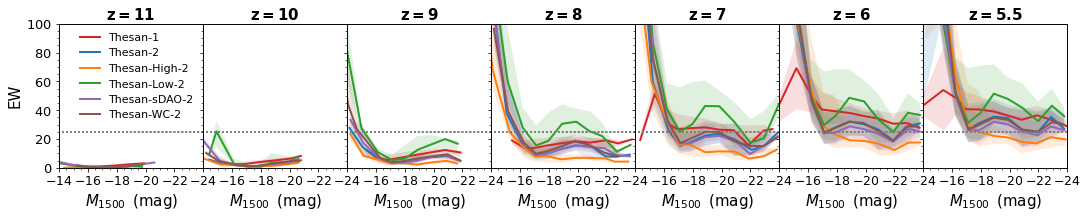

In [8]:
def plot_EW_M1500():
    n_bands = 5
    dax = 2.
    fax = 1. / float(n_bands)
    fig = plt.figure(figsize=(5.*dax,dax))
    
    n_zs = 7
    snaps = [22, 27, 34, 43, 54, 70, 80]
    ss = [s11, s10, s9, s8, s7, s6, s5]
    colors = {'Thesan-1': 'C3', 'Thesan-2': 'C0', 'Thesan-High-2': 'C1', 'Thesan-Low-2': 'C2', 'Thesan-sDAO-2': 'C4', 'Thesan-WC-2': 'C5'}
    titles = [r'z = 11', r'z = 10', r'z = 9', r'z = 8', r'z = 7', r'z = 6', r'z = 5.5']
    n_LOS = 12 * 4**3
    
    sims = ['Thesan-1', 'Thesan-2', 'Thesan-High-2', 'Thesan-Low-2', 'Thesan-sDAO-2', 'Thesan-WC-2']
#     sims = ['Thesan-1', 'Thesan-2', 'Thesan-sDAO-2', 'Thesan-WC-2']
    n_sims = len(sims)

    sightline = 0
    
    for i_z in range(n_zs):
        ax = plt.axes([float(i_z)*fax,0.,fax,1.])
        
        new_sims = ['Thesan-1', 'Thesan-2', 'Thesan-High-2', 'Thesan-Low-2', 'Thesan-sDAO-2', 'Thesan-WC-2']
#         new_sims = ['Thesan-1', 'Thesan-2', 'Thesan-sDAO-2', 'Thesan-WC-2']

        for i in range(len(new_sims)):
            sim = new_sims[i]
            snap = snaps[i_z]
            
            s = s_lya[snap][sim]
            y = s['EW_obs'][:]
            x = np.copy(s['M1500'])
            mask = (x < 0.)
            y = y[mask]
            x = x[mask]
            n_groups = len(x)
            
            x_lims,x_bins = [-24.5, -12.5], 13
            x_edges = np.linspace(x_lims[0], x_lims[1], x_bins)
            
            x_50 = np.zeros(x_bins)
            y_50 = np.zeros(x_bins)
            y_16 = np.zeros(x_bins)
            y_84 = np.zeros(x_bins)
            for ix in range(x_bins-1):
                mask = (x >= x_edges[ix]) & (x < x_edges[ix+1])
                if np.count_nonzero(mask) > 0:
                    x_50[ix] = np.median(x[mask])
                    y_50[ix], y_16[ix], y_84[ix] = np.percentile(y[mask], percentiles)
                else:
                    x_50[ix] = np.NaN
            ax.fill_between(x_50, y_16, y_84, lw=0., color=colors[sim], alpha=.15, zorder=-2*i_z)
            ax.plot(x_50, y_50, c=colors[sim], lw=2., label=sim)
            
            ax.plot([-24, -14], [25, 25], color='0.5', ls=':')
            
        if i_z == 0: leg = ax.legend(loc='upper right', frameon=False, borderaxespad=0.4, handlelength=1.8, ncol=1, fontsize=11.)
        
        ## Plot labels ##
        ax.set_xlabel(r'$M_{1500}\ \,(\rm{mag})$', fontsize=15)
        xmin, xmax = [-24., -14.]
        x_lims = [-24., -14.]
        ax.set_xlim(x_lims)
        ticks = np.linspace(xmin, xmax, int((xmax-xmin)/2+1))
        if i_z > 0: ticks = ticks[:-1]
        ax.set_xticks(ticks); ax.set_xticklabels([r'$%g$' % tick for tick in ticks], fontsize=12.5)
        ax.invert_xaxis()

        y_lims = [0., 100.]
        ymin, ymax = [y_lims[0], y_lims[1]]
        ax.set_ylim(ymin, ymax)
        ticks = np.linspace(ymin, ymax, 6)
        if i_z == 0:
            ax.set_yticks(ticks); ax.set_yticklabels([r'$%g$' % tick for tick in ticks], fontsize=13)
            ax.set_ylabel('EW', fontsize=15)
        else:
            ax.set_yticks(ticks); ax.set_yticklabels(['' for tick in ticks], fontsize=13)
        
        ax2 = ax.twiny()
        ax2.set_xlabel(r'${\bf '+titles[i_z]+'}$', fontsize=15)
        ax2.set_xticks([])
        
        ax.minorticks_on()
        
    fig.savefig(f'x_emulated_figures/ew_M1500_finaltest.pdf', bbox_inches='tight', transparent=True, dpi=300, pad_inches=0.025)
    plt.show()
    plt.close()

plot_EW_M1500()

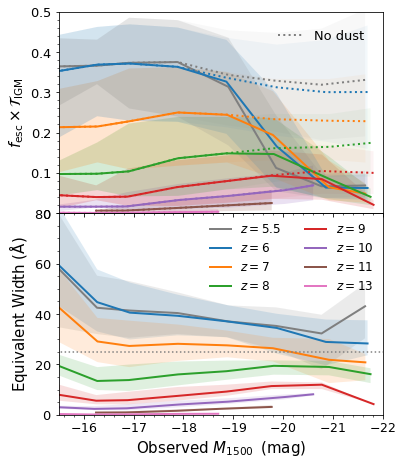

In [10]:
def plot_EW_z():
#     snaps = [14, 22, 27, 34, 43, 54, 70, 80]
    snaps = [80, 70, 54, 43, 34, 27, 22, 14]
    sim='Thesan-1'
    colors = {14: 'C6', 22: 'C5', 27: 'C4', 34: 'C3', 43: 'C2', 54: 'C1', 70: 'C0', 80: 'C7'}
#     labels = [r'$z=13$', r'$z=11$', r'$z=10$', r'$z=9$', r'$z=8$', r'$z=7$', r'$z=6$', r'$z=5.5$']
    labels = [r'$z=5.5$', r'$z=6$', r'$z=7$', r'$z=8$', r'$z=9$', r'$z=10$', r'$z=11$', r'$z=13$']
    
    fig = plt.figure(figsize=(4.5,4))
    ax = plt.axes([0,0,1,.7])
    
    ax.set_xlabel(r'Observed $M_{1500}\ \,(\rm{mag})$', fontsize=15)
    xmin, xmax = [-22., -15.5]
    x_lims = [-22., -15.5]
    ax.set_xlim(x_lims)
    ticks = np.linspace(-22, -16, 7)
    ax.set_xticks(ticks); ax.set_xticklabels([r'$%g$' % tick for tick in ticks], fontsize=12.5)
    ax.invert_xaxis()

    ax.set_ylabel(r'Equivalent Width (${\rm \AA}$)', fontsize=15)
    ymin, ymax = [0., 80.]
    y_lims = [0., 80.]
    ax.set_ylim(y_lims)
    ticks = np.linspace(ymin, ymax, 5)
    ax.set_yticks(ticks); ax.set_yticklabels([r'$%g$' % tick for tick in ticks], fontsize=13)
    
    for i in range(len(snaps)):
        snap = snaps[i]

        s = s_lya[snap][sim]
        y = s['EW_obs'][:]
        x = np.copy(s['M1500_obs_nolim'])
        mask = (x < 0.)
        y = y[mask]
        x = x[mask]
        n_groups = len(x)

        x_lims,x_bins = [-24.5, -12.5], 13
        x_edges = np.linspace(x_lims[0], x_lims[1], x_bins)

        x_50 = np.zeros(x_bins)
        y_50 = np.zeros(x_bins)
        y_16 = np.zeros(x_bins)
        y_84 = np.zeros(x_bins)
        for ix in range(x_bins-1):
            mask = (x >= x_edges[ix]) & (x < x_edges[ix+1])
            if np.count_nonzero(mask) > 0:
                x_50[ix] = np.median(x[mask])
                y_50[ix], y_16[ix], y_84[ix] = np.percentile(y[mask], percentiles)
            else:
                x_50[ix] = np.NaN
        ax.fill_between(x_50, y_16, y_84, lw=0., color=colors[snap], alpha=.15)
        ax.plot(x_50, y_50, c=colors[snap], lw=2., label=labels[i])
        
    leg = ax.legend(loc='upper right', frameon=False, borderaxespad=0.4, handlelength=1.75, fontsize=12., ncol=2)
    
    ax.plot([-24, -14], [25, 25], color='0.5', ls=':')
    ax.minorticks_on()
    
    ### x vs M1500 ###
    n_zs = 7
    snaps = [80, 70, 54, 43, 34, 27, 22, 14]
    labels = [r'$z = 5.5$', r'$z = 6$', r'$z = 7$', r'$z = 8$', r'$z = 9$', r'$z = 10$', r'$z = 11$', r'$z = 13$']
    colors = {14: 'C6', 22: 'C5', 27: 'C4', 34: 'C3', 43: 'C2', 54: 'C1', 70: 'C0', 80: 'C7'}
    n_LOS = 12 * 4**3
    sim = 'Thesan-1'
    
    ax = plt.axes([0.,0.7,1.,0.7])

    for i in range(len(snaps)):
        snap = snaps[i]
        tau_dir = '/nfs/mvogelsblab001/Thesan/Thesan-1/postprocessing/tau'
        
        # with dust model
        filename = tau_dir + f'/X_emulated/X_emulated_{snap:03d}.hdf5'

        with h5py.File(filename, 'r') as f:
            y = f['Xs'][:,:]

        xp = np.copy(s_lya[snap][sim]['M1500_obs_nolim'])
#         EW_obs = s_lya[snap][sim]['EW_obs']
        mask = (xp < 0.)

        y = y[mask,:]
        xp = xp[mask]
        n_groups = len(xp)
        x = np.zeros([n_groups, n_LOS])
        for i_LOS in range(n_LOS):
            x[:,i_LOS] = xp[:]
        x = x.flatten()
        y = y.flatten()

        x_lims,x_bins = [-24.5, -12.5], 13
        x_edges = np.linspace(x_lims[0], x_lims[1], x_bins)

        x_50 = np.zeros(x_bins)
        y_50 = np.zeros(x_bins)
        y_16 = np.zeros(x_bins)
        y_84 = np.zeros(x_bins)
        for ix in range(x_bins-1):
            mask = (x >= x_edges[ix]) & (x < x_edges[ix+1])
            if np.count_nonzero(mask) > 0:
                x_50[ix] = np.median(x[mask])
                y_50[ix], y_16[ix], y_84[ix] = np.percentile(y[mask], percentiles)
            else:
                x_50[ix] = np.NaN
        ax.fill_between(x_50, y_16, y_84, lw=0., color=colors[snap], alpha=.15, zorder=-2*i)
        ax.plot(x_50, y_50, c=colors[snap], lw=2.)

        # no dust model
        filename = tau_dir + f'/X_emulated/X_emulated_nodust_{snap:03d}.hdf5'

        with h5py.File(filename, 'r') as f:
            y = f['Xs'][:,:]

        xp = np.copy(s_lya[snap][sim]['M1500_obs_nolim'])
#         EW_obs = s_lya[snap][sim]['EW_obs']
        mask = (xp < 0.)

        y = y[mask,:]
        xp = xp[mask]
        n_groups = len(xp)
        x = np.zeros([n_groups, n_LOS])
        for i_LOS in range(n_LOS):
            x[:,i_LOS] = xp[:]
        x = x.flatten()
        y = y.flatten()

        x_lims,x_bins = [-24.5, -12.5], 13
        x_edges = np.linspace(x_lims[0], x_lims[1], x_bins)

        x_50 = np.zeros(x_bins)
        y_50 = np.zeros(x_bins)
        y_16 = np.zeros(x_bins)
        y_84 = np.zeros(x_bins)
        for ix in range(x_bins-1):
            mask = (x >= x_edges[ix]) & (x < x_edges[ix+1])
            if np.count_nonzero(mask) > 0:
                x_50[ix] = np.median(x[mask])
                y_50[ix], y_16[ix], y_84[ix] = np.percentile(y[mask], percentiles)
            else:
                x_50[ix] = np.NaN
        ax.fill_between(x_50, y_16, y_84, lw=0., color=colors[snap], alpha=.05, zorder=-2*i)
        if snap==80:
            ax.plot(x_50, y_50, c=colors[snap], lw=2., ls=':', label='No dust')
        else:
            ax.plot(x_50, y_50, c=colors[snap], lw=2., ls=':')

    leg = ax.legend(loc='upper right', frameon=False, borderaxespad=1., handlelength=2., ncol=1, fontsize=13.)

    ## Plot labels ##
#     ax.set_xlabel(r'$M_{1500}\ \,(\rm{mag})$', fontsize=15)
    xmin, xmax = [-22., -15.5]
    x_lims = [-22., -15.5]
    ax.set_xlim(x_lims)
    ticks = np.linspace(-22, -16, 7)
    ax.set_xticks(ticks); ax.set_xticklabels([])
    ax.invert_xaxis()

    y_lims = [0., 0.5]
    ymin, ymax = [y_lims[0], y_lims[1]]
    ax.set_ylim(y_lims)
    ticks = np.linspace(ymin, ymax, 6)
    ax.set_yticks(ticks); ax.set_yticklabels([r'$%g$' % tick for tick in ticks], fontsize=13)
    ax.set_ylabel(r'$f_{\rm esc} \times \mathcal{T}_{\rm IGM}$', fontsize=15)

    ax.minorticks_on()

    fig.savefig('x_emulated_figures/ew_x_M1500_z.pdf', bbox_inches='tight', transparent=True, dpi=300, pad_inches=0.025)
    plt.show()
    plt.close()
    
plot_EW_z()

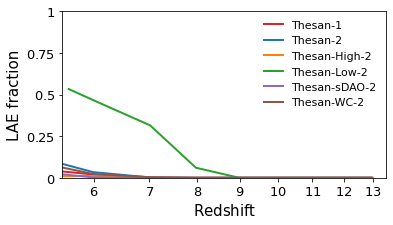

In [14]:
def plot_LAEfrac():
    sims = ['Thesan-1', 'Thesan-2', 'Thesan-High-2', 'Thesan-Low-2', 'Thesan-sDAO-2', 'Thesan-WC-2']
    colors = {'Thesan-1': 'C3', 'Thesan-2': 'C0', 'Thesan-High-2': 'C1', 'Thesan-Low-2': 'C2', 'Thesan-sDAO-2': 'C4', 'Thesan-WC-2': 'C5'}
    
    fig = plt.figure(figsize=(4.5,3.3))
    ax = plt.axes([0,.3,1,.7])
    
    ax.set_xlabel(r'${\rm Redshift}$', fontsize=15)
    ax.set_ylabel('LAE fraction', fontsize=15)
    ax.set_xscale('log')
    xmin, xmax = [5.5, 13.5]
    x_lims = [5.5, 13.5]
    ymin, ymax = [0., 1.]
    y_lims = [0., 1.]
    ax.set_xlim(x_lims)
    ax.set_ylim(y_lims)
    
    ticks = np.linspace(6, 13, 8)
    ax.set_xticks(ticks); ax.set_xticklabels([r'$%g$' % tick for tick in ticks], fontsize=13)
    ticks = np.linspace(ymin, ymax, 5)
    ax.set_yticks(ticks); ax.set_yticklabels([r'$%g$' % tick for tick in ticks], fontsize=13)
    
    for sim in sims:
        snaps = [14, 22, 27, 34, 43, 54, 70, 80]
        y = np.zeros(len(snaps))
        x = np.zeros(len(snaps))
        for i in range(len(snaps)):
            snap = snaps[i]
            s = s_lya[snap][sim]
            lumcut = s['M1500']
            EW_obs = s['EW_obs']
            lummask = ((lumcut < -18.75) & (lumcut > -20.25))
            fullmask = ((lumcut < -18.75) & (lumcut > -20.25) & (EW_obs > 25.))
            LAEs = s['Lya'][fullmask]
            n_galaxies = len(s['Lya'][lummask])
            n_LAEs = len(LAEs)
            if n_galaxies == 0:
                y[i] = 0
            else:
                y[i] = n_LAEs/n_galaxies
            x[i] = s['Redshift']

#         ax.fill_between(x_50, y_16, y_84, lw=0., color=colors[sim], alpha=.1)
        ax.plot(x, y, c=colors[sim], lw=2., label=sim)
    
    stark_z = np.array([5.87, 7.12])
    stark_x = np.array([0.54, 0.24])
    stark_low = np.array([0.43, 0.09])
    stark_high = np.array([0.65, 0.39])
    
    fuller_z = np.array([5.6, 6.56])
    fuller_x = np.array([0.29, 0.43])
    fuller_high = np.array([0.36,0.57])
    fuller_low = np.array([0.25, 0.33])
    
    debarros_z = np.array([6.0])
    debarros_x = np.array([0.36])
    debarros_high = np.array([0.47])
    debarros_low = np.array([0.28])

    schenker_z = np.array([7.0, 8.0])
    schenker_x = np.array([0.24, 0])
    schenker_high = np.array([0.35, 0.09])
    schenker_low = np.array([0.18, 0])

    hoag_z = np.array([7.195])
    hoag_x = np.array([0.05])
    hoag_high = np.array([0.07])
    hoag_low = np.array([0.01])
    
    pentericci_z = np.array([7.0])
    pentericci_x = np.array([0.14])
    pentericci_high = np.array([0.22])
    pentericci_low = np.array([0.07])

    tilvi_z = np.array([7.82])
    tilvi_x = np.array([0.25])
    
#     cross_z = np.array([7.90])
#     cross_x = np.array([0.11])
    
#     kwargs = {'zorder':20, 'alpha':1., 'color':[.3,.3,.3], 'lw':0., 'elinewidth':1.}
#     # 'ms':2, 'elinewidth':1., 'lw':0., 
#     ax.errorbar(stark_z, stark_x, [stark_x-stark_low, stark_high-stark_x], **kwargs, marker='o')
#     ax.errorbar(fuller_z, fuller_x, [fuller_x-fuller_low, fuller_high-fuller_x], **kwargs, marker='p')
#     ax.errorbar(debarros_z, debarros_x, [debarros_x-debarros_low, debarros_high-debarros_x], **kwargs, marker='^')
#     ax.errorbar(schenker_z, schenker_x, [schenker_x-schenker_low, schenker_high-schenker_x], **kwargs, marker='h')
#     ax.errorbar(hoag_z, hoag_x, [hoag_x-hoag_low, hoag_high-hoag_x], **kwargs, marker='s')
#     ax.errorbar(pentericci_z, pentericci_x, [pentericci_x-pentericci_low, pentericci_high-pentericci_x], **kwargs, marker='*')
#     ax.errorbar(tilvi_z, tilvi_x, yerr=0.1, uplims=True, lolims=False, **kwargs, marker='v')
#     p0, = ax.plot([0], [0], lw=1., c=[.3,.3,.3], label='Observations')
    
    #legend
    leg = ax.legend(loc='upper right', frameon=False, borderaxespad=0.4, handlelength=1.75, fontsize=11.)
#     leg2 = ax2.legend(loc='center right', frameon=False, borderaxespad=0.5, handlelength=2.4, ncol=1, fontsize=12.)

    fig.savefig('x_emulated_figures/ewfixed_withcut_LAEfrac.pdf', bbox_inches='tight', transparent=True, dpi=300, pad_inches=0.025)
    plt.show()
    plt.close()

plot_LAEfrac()